In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
DATASET_PATH = "/kaggle/input/h-and-m-personalized-fashion-recommendations"
print(os.listdir(DATASET_PATH))

['sample_submission.csv', 'articles.csv', 'transactions_train.csv', 'images', 'customers.csv']


In [9]:
articles = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def plot_images(image_folder, num_images=10):
    count = 0  
    
    # Calculate the number of rows and columns for subplots
    num_cols = min(num_images, 5)  
    num_rows = -(-num_images // num_cols)  
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))  # Adjust figsize as per your preference
    
    # Iterate through the image folder and its subfolders
    for root, dirs, files in os.walk(image_folder):
        for file in files:
            
            # Check if the file is an image (you can add more image file extensions if needed)
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                image_path = os.path.join(root, file)

                image = Image.open(image_path)

                ax = axes[count // num_cols, count % num_cols] if num_rows > 1 else axes[count % num_cols]
                ax.imshow(image)
                ax.set_title(file)  
                ax.axis('off')  

                count += 1

                # Check if the maximum number of images to plot has been reached
                if count >= num_images:
                    break

    # Hide any unused subplots
    for i in range(count, num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        ax.axis('off')

    plt.tight_layout()
    plt.show()


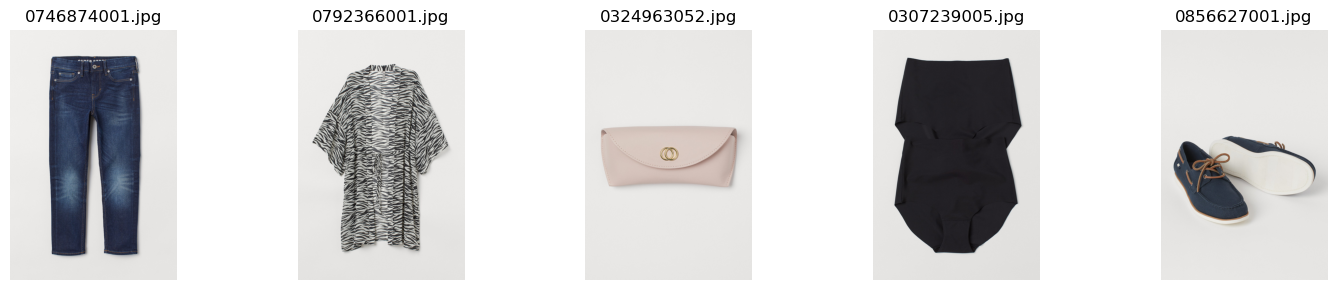

In [11]:
image_folder = "/kaggle/input/h-and-m-personalized-fashion-recommendations/images"
plot_images(image_folder, num_images=5)  


In [12]:
root_folder = '/kaggle/input/h-and-m-personalized-fashion-recommendations/images'

folder_names = sorted(os.listdir(root_folder))[:30] #choose how many folders you want to input

In [13]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

resnet = models.resnet50(pretrained=True)
resnet.eval()

# Preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]  
    )
])


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
# Initialize lists to store embeddings and image paths
embeddings = []
image_paths = []

for folder_name in folder_names:
    folder_path = os.path.join(root_folder, folder_name)
    image_files = sorted(os.listdir(folder_path))
    
    #load images into tensors
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path).convert('RGB')
        image_tensor = preprocess(image)
        image_tensor = Variable(image_tensor.unsqueeze(0))  # Add batch dimension

        # Forward pass through ResNet model and obtain features 
        with torch.no_grad():
            features = resnet(image_tensor)

        # Extract embeddings
        embeddings.append(features.squeeze().numpy())
        image_paths.append(image_path)

In [15]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [16]:
# Convert embeddings to NumPy array
embeddings = np.array(embeddings)

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(embeddings)



In [17]:
def get_recommendations(idx, sim_matrix, top_n=5):
    
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]
    idx_rec = [i[0] for i in sim_scores]
    return idx_rec

In [18]:
index_map = {}  # Create an index_map dictionary

for i, image_path in enumerate(image_paths):
    image_name = os.path.basename(image_path)  
    index_map[image_name] = i  
    

idx_ref: 0211143037.jpg


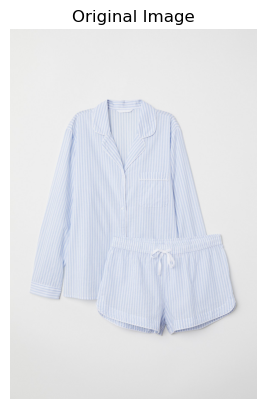

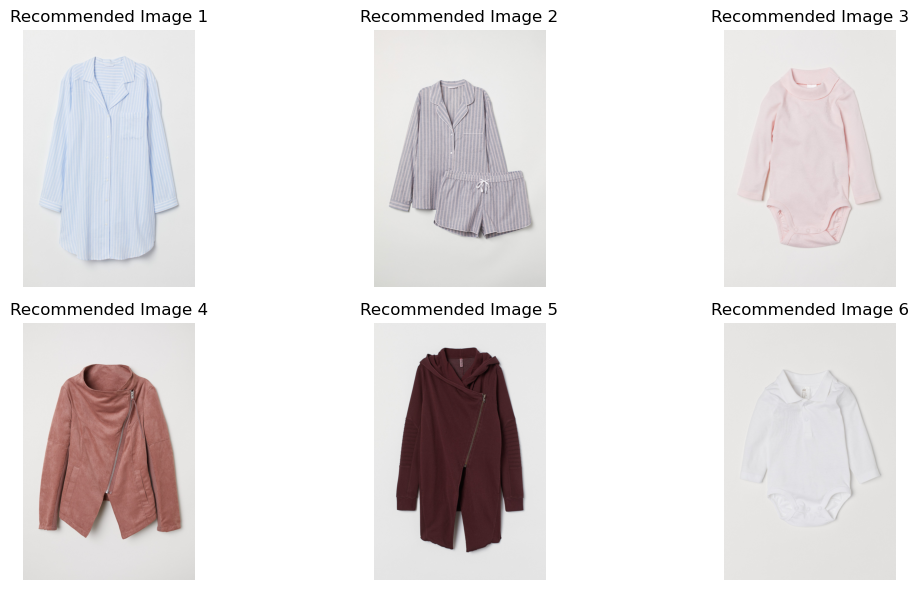

In [19]:
idx_ref = "0211143037" #proposed image id 
idx_ref_with_extension = idx_ref + ".jpg"
print("idx_ref:", idx_ref_with_extension)

if idx_ref_with_extension in index_map:
    idx_ref_index = index_map[idx_ref_with_extension]  # Get the index of idx_ref from index_map

    # Get recommendations
    idx_rec = get_recommendations(idx_ref_index, cosine_sim, top_n=6)
    original_image = Image.open(image_paths[idx_ref_index])
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(idx_rec):
        image = Image.open(image_paths[idx])
        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.title(f'Recommended Image {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f"Invalid idx_ref: {idx_ref_with_extension}")
